In [24]:
import h5py
import numpy as np

# Path to your HDF5 file
file_path = '5G_dataset/5G_training_data.hdf5'

# Create an empty dictionary to store NumPy arrays
data_dict = {}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Iterate over all datasets in the file
    for key in hdf.keys():
        dataset = hdf[key][:]
        data_dict[key] = dataset  # Store each dataset into the dictionary

# Now, you can access individual datasets as NumPy arrays
A_ID = data_dict['A_ID']
B_ID = data_dict['B_ID']
CIR_I = data_dict['CIR_I']
CIR_R = data_dict['CIR_R']
POS_X = data_dict['POS_X']
POS_Y = data_dict['POS_Y']
TD = data_dict['TD']
TD_OFFSET = data_dict['TD_OFFSET']
TIME_STAMP = data_dict['TIME_STAMP']

# For verification, print shapes of arrays
for key, value in data_dict.items():
    print(f"{key} shape: {value.shape}")

A_ID shape: (113203,)
B_ID shape: (113203,)
CIR_I shape: (113203, 128)
CIR_R shape: (113203, 128)
POS_X shape: (113203,)
POS_Y shape: (113203,)
TD shape: (113203,)
TD_OFFSET shape: (113203,)
TIME_STAMP shape: (113203,)


In [25]:
CIR=CIR_R+ 1j*CIR_I

In [26]:
CIR.shape

(113203, 128)

In [27]:
grt_pos=np.stack((POS_X, POS_Y), axis=1)

In [28]:
def feature_extraction_F1(cir_matrix):
    R = np.convolve(cir_matrix , np.conj(cir_matrix))
    r = R.flatten()
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector

features_F1_cir = np.array([feature_extraction_F1(cir) for cir in CIR])
print("Shape of Features (F1_cir):", features_F1_cir.shape)

Shape of Features (F1_cir): (113203, 510)


In [29]:
features_F1_cir[0]

array([ 1.70655933e-05, -1.57756242e-05,  1.62629203e-05, -3.11934610e-06,
        2.63049441e-06,  1.48006018e-05, -1.36098791e-05, -1.73581537e-06,
       -1.76060987e-06,  1.11801210e-05,  5.97812230e-06,  4.20350708e-06,
       -6.29517897e-08, -2.64088928e-07,  1.75052755e-05, -1.35115645e-05,
        2.04371999e-05, -4.03672142e-06, -5.00767019e-06,  3.24120805e-05,
       -3.45230426e-05,  4.23954012e-05, -1.57527548e-05, -1.83872056e-05,
        6.15199616e-05, -7.39880448e-05,  6.80433810e-05, -1.01357764e-05,
       -4.61772479e-05,  1.03609039e-04, -1.12505062e-04,  9.25186850e-05,
       -4.86497124e-07, -7.37082963e-05,  1.71012685e-04, -1.71287767e-04,
        1.27859193e-04,  1.77372688e-05, -1.50280460e-04,  2.64101557e-04,
       -2.51315770e-04,  1.53850516e-04,  5.74400149e-05, -2.62629303e-04,
        4.04167213e-04, -3.83183543e-04,  1.93471975e-04,  1.35707786e-04,
       -4.74427180e-04,  6.92924427e-04, -6.35219323e-04,  2.75725996e-04,
        3.32610276e-04, -

In [30]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(features_F1_cir, grt_pos, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

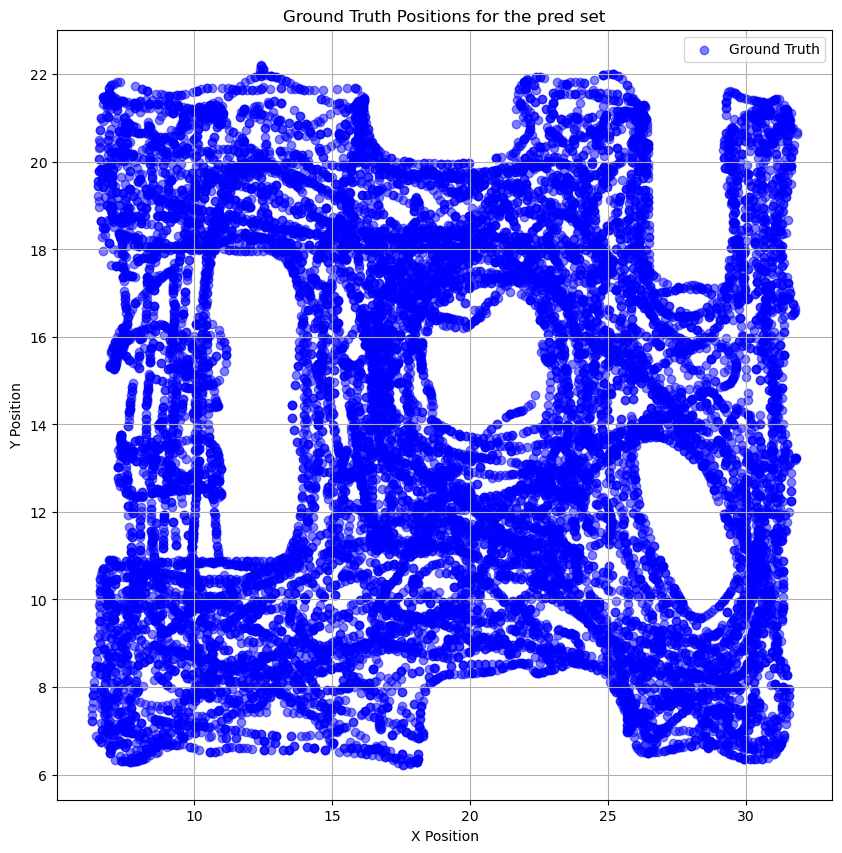

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the pred set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

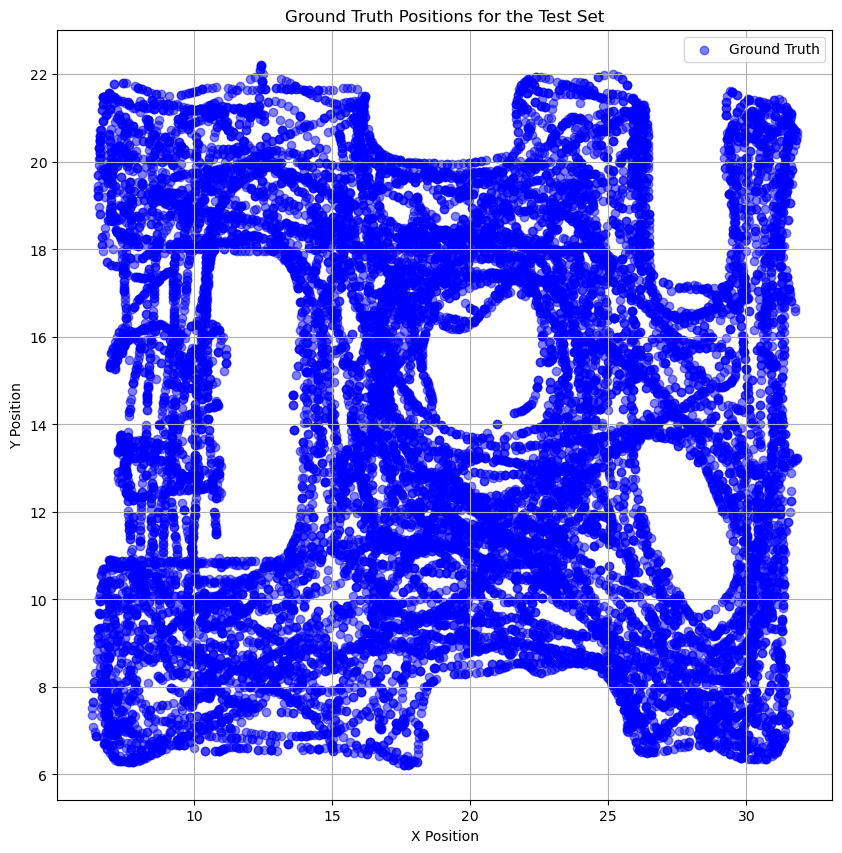

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the Test Set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

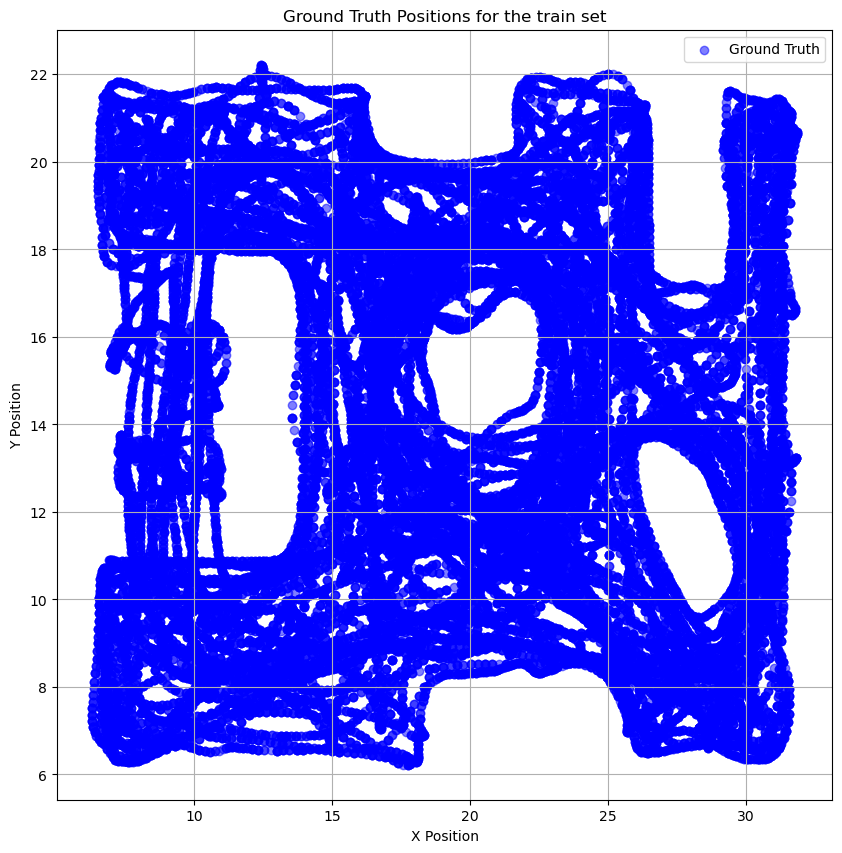

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train[:, 0], y_train[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the train set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
import numpy as np

def build_grid(grid_size=30, space_bounds=None):
    """
    Constructs a 2D grid of points within given space bounds.

    Parameters:
        grid_size (int): Number of grid points along each axis.
        space_bounds (tuple): ((xmin, xmax), (ymin, ymax)) bounds of the space.

    Returns:
        np.ndarray: (grid_size^2, 2) array of grid point coordinates.
    """
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_hard_probability_maps(positions, grid_points):
    """
    For each position, assign a probability of 1 to the nearest grid point.

    Parameters:
        positions (np.ndarray): (N, 2) array of actual positions.
        grid_points (np.ndarray): (K, 2) array of grid coordinates.

    Returns:
        np.ndarray: (N, K) one-hot encoded probability maps.
    """
    N = positions.shape[0]
    K = grid_points.shape[0]

    # Compute Euclidean distances between positions and grid points
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)

    # Index of nearest grid point for each position
    nearest_idx = np.argmin(dists, axis=1)

    # Create one-hot probability map
    prob_maps = np.zeros((N, K))
    prob_maps[np.arange(N), nearest_idx] = 1.0

    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    """
    Estimate positions by weighted average using probability maps.

    Parameters:
        prob_maps (np.ndarray): (N, K) probability map.
        grid_points (np.ndarray): (K, 2) grid coordinates.

    Returns:
        np.ndarray: (N, 2) estimated positions.
    """
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30):
    """
    Generates hard probability maps and estimated positions.

    Parameters:
        positions (np.ndarray): (N, 2) true positions.
        grid_size (int): Number of points along each grid axis.

    Returns:
        tuple: (prob_maps, est_locations, grid_points)
    """
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()

    print("Position bounds:", (x_min, x_max), (y_min, y_max))

    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)

    prob_maps = compute_hard_probability_maps(positions, grid_points)
    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points

In [35]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(30, 30), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

In [36]:
prob_map, est_locations, grid_points = generate_all_probability_maps(grt_pos, grid_size=30)

Position bounds: (6.307980483846373, 31.837173051937405) (6.22329557621037, 22.22057926919299)
Grid points shape: (900, 2)


In [37]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=30)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=30)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=30)

Position bounds: (6.307980483878724, 31.82647141325833) (6.223295579572582, 22.220579267617712)
Grid points shape: (900, 2)
Position bounds: (6.307980483846373, 31.837173051937405) (6.22329557621037, 22.22057926919299)
Grid points shape: (900, 2)
Position bounds: (6.307980484593721, 31.837173049773977) (6.223707326117879, 22.220579267647388)
Grid points shape: (900, 2)


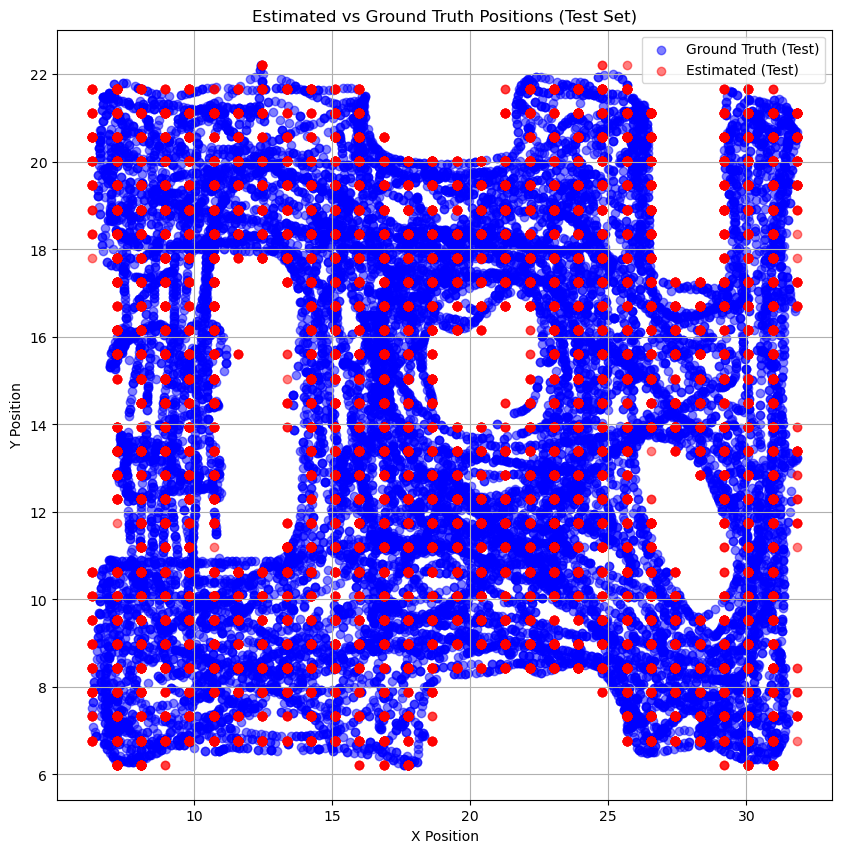

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.5)
plt.scatter(est_locations_test[:, 0], est_locations_test[:, 1], c='red', label='Estimated (Test)', alpha=0.5)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

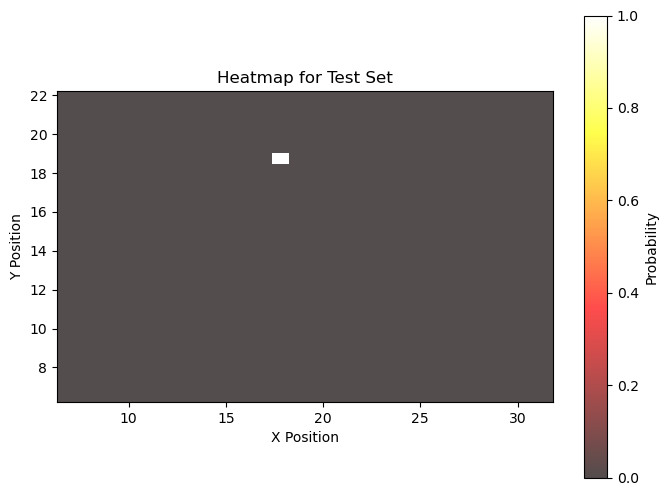

In [39]:
#diplaying the heatmap for test set
plot_heatmap(prob_map_test[0], grid_points_test, title="Heatmap for Test Set")

In [ ]:
import tensorflow as tf
from keras import layers, models, regularizers

# def build_csi_probmap_mlp(input_dim: int = 510,hidden_units: tuple = (256, 256, 256,128),dropout_rate: float = 0.2,l2_coeff: float = 0) -> tf.keras.Model:
#     inputs = layers.Input(shape=(input_dim,))
#     x = inputs
#     for i, width in enumerate(hidden_units, start=1):
#         x = layers.Dense(width, activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_coeff))(x)
#         x = layers.Dropout(dropout_rate)(x)
#     logits = layers.Dense(900, activation=None)(x)
#     outputs = layers.Activation("softmax")(logits)
#     return models.Model(inputs, outputs)

def build_csi_probmap_mlp(input_dim: int = 510,hidden_units: tuple = (1024, 1024, 512, 256),dropout_rate: float = 0.2,l2_coeff: float = 0.0) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for width in hidden_units:
        x = layers.Dense(width,activation='gelu',kernel_regularizer=regularizers.l2(l2_coeff))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(900, activation=None)(x)
    outputs = layers.Activation("sigmoid")(logits)
    return models.Model(inputs, outputs)


In [ ]:
pred_ds = tf.data.Dataset.from_tensor_slices((X_pred, prob_map_pred))
pred_ds = pred_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, prob_map_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, prob_map_test))
test_ds = test_ds.shuffle(buffer_size=1024).batch(32)

In [ ]:
model2 = build_csi_probmap_mlp()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model2.fit(train_ds, epochs=30, validation_data=pred_ds)

1924/2123 [==========================>...] - ETA: 2s - loss: 0.0072 - accuracy: 0.0582

KeyboardInterrupt: 

In [41]:
model2.fit(train_ds, epochs=20, validation_data=pred_ds)

Epoch 1/20
2123/2123 [==============================] - 26s 12ms/step - loss: 0.0071 - accuracy: 0.0620 - val_loss: 0.0073 - val_accuracy: 0.0551
Epoch 2/20
2123/2123 [==============================] - 25s 12ms/step - loss: 0.0070 - accuracy: 0.0633 - val_loss: 0.0073 - val_accuracy: 0.0564
Epoch 3/20
2123/2123 [==============================] - 25s 12ms/step - loss: 0.0070 - accuracy: 0.0674 - val_loss: 0.0073 - val_accuracy: 0.0574
Epoch 4/20
2123/2123 [==============================] - 25s 12ms/step - loss: 0.0069 - accuracy: 0.0698 - val_loss: 0.0073 - val_accuracy: 0.0587
Epoch 5/20
2123/2123 [==============================] - 26s 12ms/step - loss: 0.0069 - accuracy: 0.0730 - val_loss: 0.0073 - val_accuracy: 0.0602
Epoch 6/20
2123/2123 [==============================] - 26s 12ms/step - loss: 0.0068 - accuracy: 0.0760 - val_loss: 0.0072 - val_accuracy: 0.0610
Epoch 7/20
2123/2123 [==============================] - 28s 13ms/step - loss: 0.0068 - accuracy: 0.0813 - val_loss: 0.0072 -

  1/708 [..............................] - ETA: 2:52

2025-07-30 17:59:10.613963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


708/708 [==============================] - 2s 2ms/step


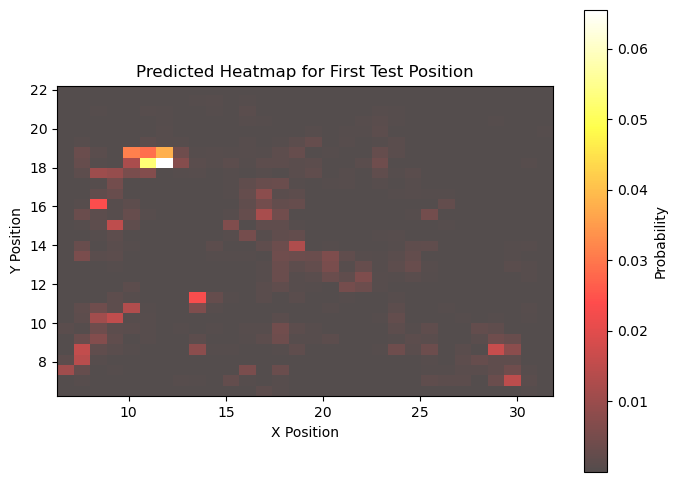

Estimated :- [13.85711741 13.19974264]
Ground Truth :- [13.7296151  10.87717977]


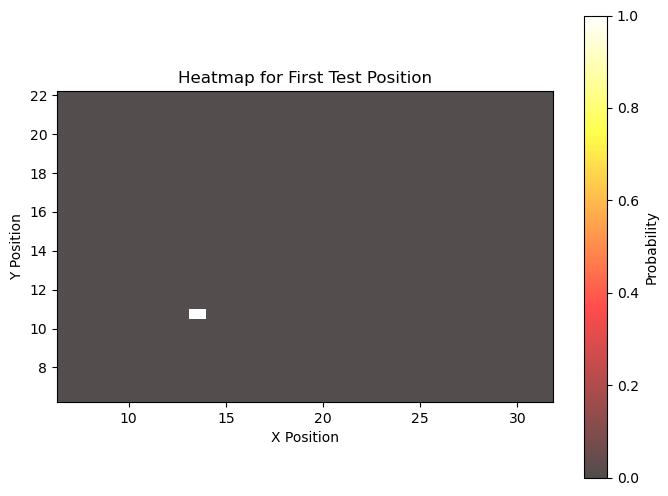

Mean Absolute Error (Position Predictions): [6.65462634 4.5466072 ]


In [42]:
predicted_maps = model2.predict(X_pred)
plot_heatmap(predicted_maps[2], grid_points_pred, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_pred)[2]}")
print(f"Ground Truth :- {y_pred[2]}")
plot_heatmap(prob_map_pred[2], grid_points_pred, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_pred)
mae = np.mean(np.abs(y_pred - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

In [43]:
jk=estimate_positions_from_maps(predicted_maps, grid_points_pred)

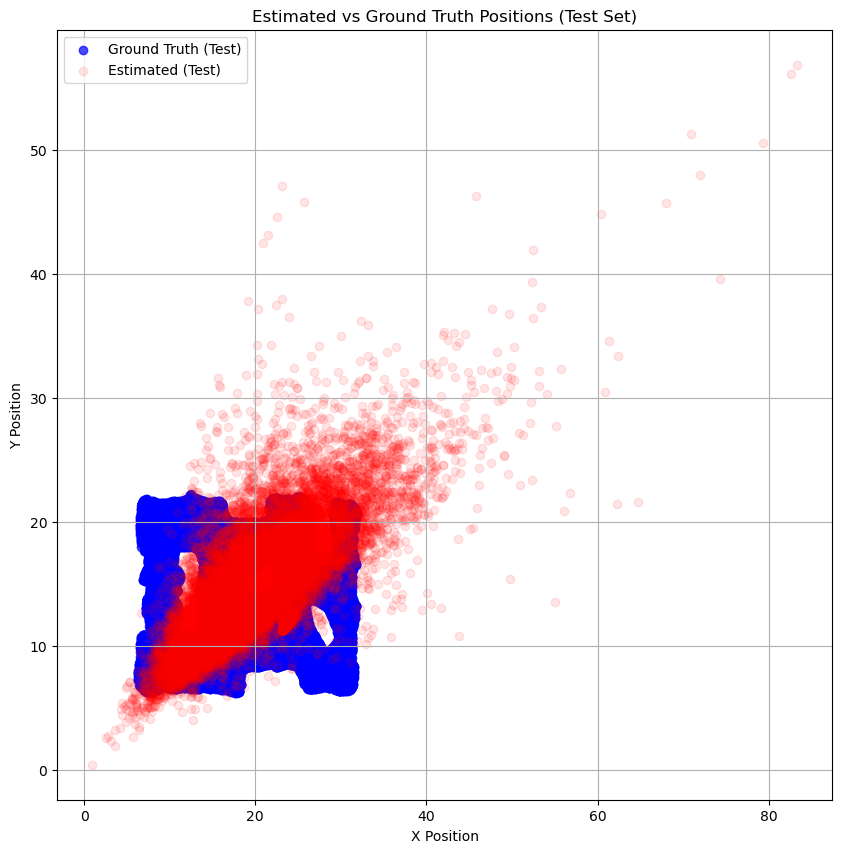

In [44]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.7)
plt.scatter(jk[:, 0], jk[:, 1], c='red', label='Estimated (Test)', alpha=0.1)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
X_train.shape

(67921, 510)

In [46]:
# Converting CIR to CFR
CFR = np.fft.fft(CIR,norm="ortho")

In [47]:
CIR.shape

(113203, 128)

In [48]:
CFR.shape

(113203, 128)

In [49]:
import numpy as np
from scipy.signal import convolve

def random_attack(CFR, *, lp=None, cp_len=0, epsilon=1.0, align='pad'):
    batch_size, n_subcarriers = CFR.shape
    A = np.random.uniform(0, 1, (batch_size, lp))  
    phi = np.random.uniform(0, 2 * np.pi, (batch_size, lp))
    base = A * (np.cos(phi) + 1j * np.sin(phi))  # shape (batch, lp)

    if cp_len:
        cp = base[:, -cp_len:]
        base = np.concatenate([cp, base], axis=-1)  # shape (batch, lp + cp_len)

    # Normalize each perturbation vector to unit ℓ₂ norm
    # Perform convolution batch-wise
    # final_cfr = np.ones_like(CFR, dtype=np.complex128)
    # for i in range(batch_size):
    #     final_cfr[i] = convolve(CFR[i], perturbation[i], mode='same')
    perturbation = np.concatenate([base,np.zeros((batch_size,CFR.shape[1]-base.shape[1]))], axis=1)
    perturbation=np.fft.fft(perturbation, axis=1)
    norm = np.linalg.norm(perturbation, axis=-1, keepdims=True)
    perturbation = perturbation / norm
    return CFR*perturbation


In [50]:
bange=range(2,17,1)

In [51]:
def feature_extraction_F12(cfr_matrix):
    cir_matrix=np.fft.ifft(cfr_matrix)
    R = np.convolve(cir_matrix , np.conj(cir_matrix))
    r = R.flatten()
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector

In [52]:
mde_vals=[]
for x in bange:
    lp_length = x
    CFR_adv = random_attack(CFR, lp=lp_length,cp_len=20,align='pad')
    features_F1_cir_adv2 = np.array([feature_extraction_F12(cir) for cir in CFR_adv])
    predicted_maps_adv2 = model2.predict(features_F1_cir_adv2)
    predicted_positions_adv2 = np.matmul(predicted_maps_adv2, grid_points)
    mde_adv2 = np.mean(np.sqrt((grt_pos[:,0]- predicted_positions_adv2[:,0])**2+(grt_pos[:,1]- predicted_positions_adv2[:,1])**2), axis=0)
    mde_vals.append(mde_adv2)

3538/3538 [==============================] - 7s 2ms/step


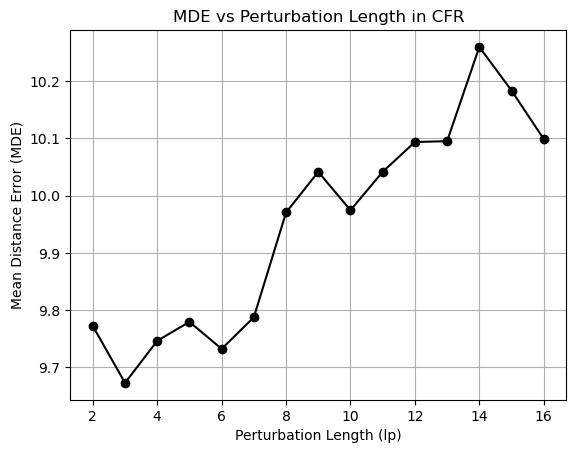

In [53]:
#plot the MDE values
import matplotlib.pyplot as plt
plt.plot(bange, mde_vals, marker='o', linestyle='-', color='black')
plt.title('MDE vs Perturbation Length in CFR')
plt.xlabel('Perturbation Length (lp)') 
plt.ylabel('Mean Distance Error (MDE)')
plt.grid(True)
plt.show()